# AIVLE스쿨 2차 미니프로젝트: 신규 아파트 주차 수요 예측

<img src = "https://github.com/Jangrae/img/blob/master/parking.png?raw=true" width=800, align="left"/>

# 단계 3: 모델링

## [미션]

- 모델링을 수행합니다.
    - 전처리를 추가로 진행합니다.
    - 4개 이상의 알고리즘을 사용해 모델링을 수행합니다.
    - 각 모델에 대해 성능 튜닝을 수행합니다.
    - 성능을 비교해 최선의 모델을 선정합니다.
- 데이터 파이프라인 함수를 만듭니다.
- 새로운 데이터를 읽어와 예측을 수행합니다.

## 1. 환경설정

### (1) 로컬 수행(Anaconda)

- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [2]:
# 기본 경로
path = ''

### (2) 구글 콜랩 수행

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [3]:
# 구글 드라이브 연결, 패스 지정
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'

### (3) 한글 폰트 표시용 라이브러리 설치

In [4]:
# 한글 표시를 위한 라이브러리 설치
!pip install koreanize_matplotlib -q

### (4) 라이브러리 불러오기

In [5]:
#!pip install xgboost
#!pip install lightgbm

In [6]:
# 기본 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 모델링용 라이브러리 불러오기
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

# 기타 라이브러리 불러기기
import joblib
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (5) 데이터 불러오기

- joblib.dump() 함수를 사용해 base_data2.pkl 파일을 읽어옵니다.
- 읽어온 데이터를 data 데이터프레임으로 선언하고 기본 정보를 확인합니다.

In [7]:
# 파일 읽어오기
data = joblib.load(path+'base_data2.pkl')

# 확인
data.head()

,총세대수,준공연도,건물형태,난방방식,승강기설치여부,실차량수,총면적,1030,3040,4050,5060,6070,7080,80200,임대보증금,임대료
0,78,2013,계단식,개별,1,109,6023.7683,0,0,0,78,0,0,0,5.696200e+07,642930.000000
1,35,2013,복도식,개별,1,35,1569.1668,35,0,0,0,0,0,0,6.306200e+07,470100.000000
2,88,2013,계단식,개별,1,88,7180.1396,0,0,0,88,0,0,0,7.219000e+07,586540.000000
3,477,2014,복도식,지역,1,943,47058.9273,0,0,0,150,0,216,111,1.015167e+08,950305.000000
4,15,2013,복도식,개별,1,21,543.0268,15,0,0,0,0,0,0,5.522750e+07,340148.333333


In [8]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   총세대수     345 non-null    int64  
 1   준공연도     345 non-null    int64  
 2   건물형태     345 non-null    object 
 3   난방방식     345 non-null    object 
 4   승강기설치여부  345 non-null    int32  
 5   실차량수     345 non-null    int64  
 6   총면적      345 non-null    float64
 7   1030     345 non-null    int64  
 8   3040     345 non-null    int64  
 9   4050     345 non-null    int64  
 10  5060     345 non-null    int64  
 11  6070     345 non-null    int64  
 12  7080     345 non-null    int64  
 13  80200    345 non-null    int64  
 14  임대보증금    345 non-null    float64
 15  임대료      345 non-null    float64
dtypes: float64(3), int32(1), int64(10), object(2)
memory usage: 41.9+ KB


In [9]:
data.describe()


,총세대수,준공연도,승강기설치여부,실차량수,총면적,1030,3040,4050,5060,6070,7080,80200,임대보증금,임대료
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,3.450000e+02,345.000000
mean,546.759420,2007.713043,0.965217,555.431884,37282.661962,45.837681,169.513043,147.455072,132.889855,1.852174,16.895652,34.515942,2.382737e+07,197729.050210
std,432.359538,7.261036,0.183495,374.640474,29588.197927,161.133746,222.935074,216.675593,252.947082,32.771294,76.441995,116.975949,2.247481e+07,158760.777669
min,1.000000,1992.000000,0.000000,21.000000,68.930000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,178.000000,2003.000000,1.000000,258.000000,11293.832100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.272491e+07,112905.000000
50%,491.000000,2008.000000,1.000000,498.000000,32190.360000,0.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.930850e+07,172000.000000
75%,853.000000,2013.000000,1.000000,822.000000,56189.979600,0.000000,298.000000,264.000000,150.000000,0.000000,0.000000,0.000000,2.837700e+07,227564.000000
max,2289.000000,2022.000000,1.000000,1657.000000,150126.863200,1181.000000,1429.000000,1258.000000,1444.000000,608.000000,756.000000,850.000000,1.898219e+08,950305.000000


### (6) 함수 생성

- 실젯값과 모델이 예측한 값을 시각화해 비교할 함수를 만듭니다.

In [10]:
# 실젯값, 예측값 비교 함수 만들기
def model_plot(y_test, y_pred):
    plt.figure(figsize=(10, 3))
    plt.plot(y_test.values, label='Actual', linewidth=0.7, marker='o', markersize=2)
    plt.plot(y_pred, label='Predicted', linewidth=0.7, marker='o', markersize=2)
    plt.legend()
    plt.show()

## 2. 모델링

- 모델링을 위한 결측치 처리, 데이터 분할, 스케일링, 가변수화 등을 수행합니다.
- 4개 이상의 알고리즘을 사용하여 모델을 만듭니다.
- 모델 이름은 서로 다르게 합니다. (예: model1, model2...)
- Linear Regression 이외의 알고리즘을 사용한 모델은 GridSearchCV() 함수로 성능 최적화를 수행합니다.
- 적절한 평가지표로 모델의 성능을 평가합니다.
- 실젯값과 예측값을 시각화해 비교합니다.
- 성능 비교를 통해 최선의 모델을 선정합니다.

### (1) 데이터 전처리

- 필요한 전처리를 수행합니다.

#### 1) 가변수화

- '건물형태', '난방방식' 변수에 대해 가변수화를 수행합니다.

In [11]:
dumm_cols = ['건물형태','난방방식']

data = pd.get_dummies(data,columns=dumm_cols,drop_first=True,dtype=int)
data

,총세대수,준공연도,승강기설치여부,실차량수,총면적,1030,3040,4050,5060,6070,7080,80200,임대보증금,임대료,건물형태_복도식,건물형태_혼합식,난방방식_중앙,난방방식_지역
0,78,2013,1,109,6023.7683,0,0,0,78,0,0,0,5.696200e+07,642930.000000,0,0,0,0
1,35,2013,1,35,1569.1668,35,0,0,0,0,0,0,6.306200e+07,470100.000000,1,0,0,0
2,88,2013,1,88,7180.1396,0,0,0,88,0,0,0,7.219000e+07,586540.000000,0,0,0,0
3,477,2014,1,943,47058.9273,0,0,0,150,0,216,111,1.015167e+08,950305.000000,1,0,0,1
4,15,2013,1,21,543.0268,15,0,0,0,0,0,0,5.522750e+07,340148.333333,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,1485,1993,1,298,64622.2500,1181,298,0,6,0,0,0,7.595571e+06,104975.714286,1,0,1,0
341,1386,1993,1,258,57616.8100,1071,298,0,17,0,0,0,8.092875e+06,111848.750000,1,0,1,0
342,956,1994,1,243,37398.7200,956,0,0,0,0,0,0,9.931000e+06,134540.000000,1,0,0,1
343,120,2020,1,47,5581.8024,66,54,0,0,0,0,0,2.515500e+06,50040.000000,1,0,0,0


In [12]:
data = data.loc[(data['임대보증금'] != 0) | (data['임대료'] !=0)]
data

,총세대수,준공연도,승강기설치여부,실차량수,총면적,1030,3040,4050,5060,6070,7080,80200,임대보증금,임대료,건물형태_복도식,건물형태_혼합식,난방방식_중앙,난방방식_지역
0,78,2013,1,109,6023.7683,0,0,0,78,0,0,0,5.696200e+07,642930.000000,0,0,0,0
1,35,2013,1,35,1569.1668,35,0,0,0,0,0,0,6.306200e+07,470100.000000,1,0,0,0
2,88,2013,1,88,7180.1396,0,0,0,88,0,0,0,7.219000e+07,586540.000000,0,0,0,0
3,477,2014,1,943,47058.9273,0,0,0,150,0,216,111,1.015167e+08,950305.000000,1,0,0,1
4,15,2013,1,21,543.0268,15,0,0,0,0,0,0,5.522750e+07,340148.333333,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,1485,1993,1,298,64622.2500,1181,298,0,6,0,0,0,7.595571e+06,104975.714286,1,0,1,0
341,1386,1993,1,258,57616.8100,1071,298,0,17,0,0,0,8.092875e+06,111848.750000,1,0,1,0
342,956,1994,1,243,37398.7200,956,0,0,0,0,0,0,9.931000e+06,134540.000000,1,0,0,1
343,120,2020,1,47,5581.8024,66,54,0,0,0,0,0,2.515500e+06,50040.000000,1,0,0,0


#### 2) x, y 분리

- Target를 지정하고, x와 y로 분리합니다.

In [13]:
target = '실차량수'


x = data.drop(target,axis=1)
y = data.loc[:,target]

#### 3) 학습용, 평가용 분리

- 학습용, 평가용 데이터를 적절한 비율로 분리합니다.

In [14]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

#### 4) 스케일링

- 필요한 경우 스케일링을 진행합니다.
- 예를 들어 KNN 알고리즘을 사용할 경우입니다.

In [15]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

### (2) 모델 1: 알고리즘 : Linear regresssion

In [16]:
result = {}

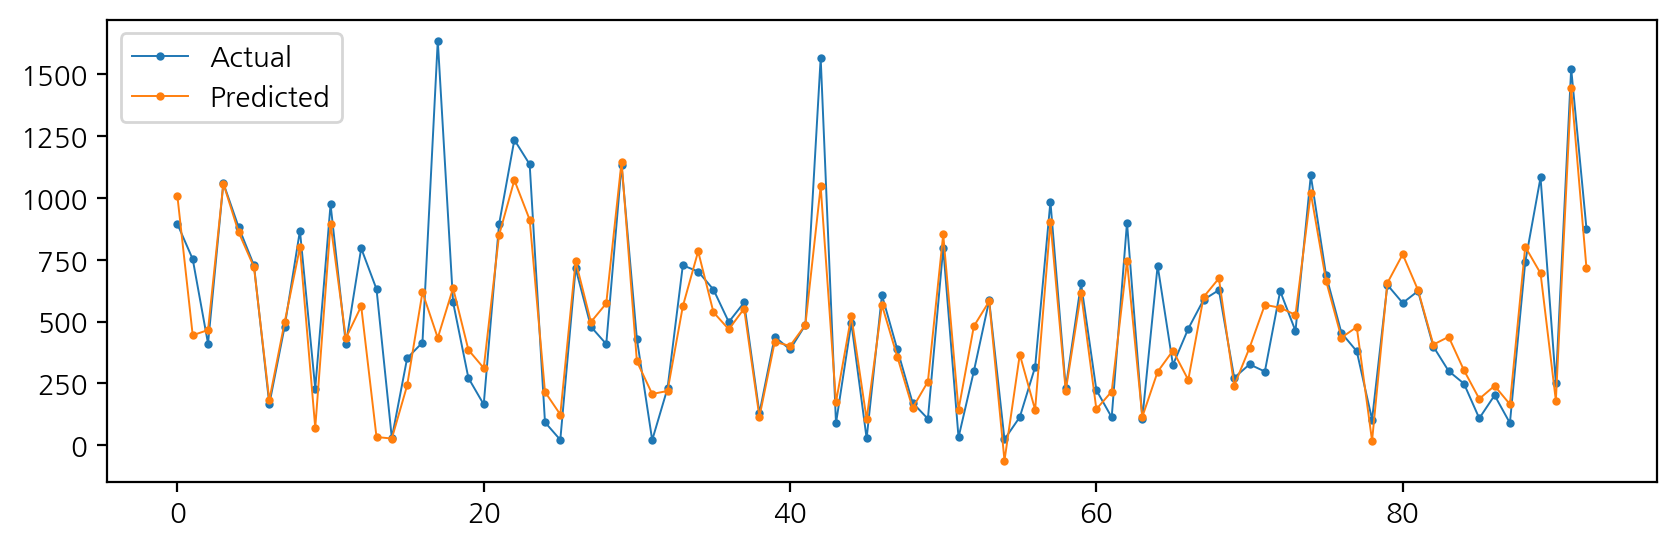

MAE :  111.1995361360024
r2_score :  0.7156301514831418


In [17]:
model_lr = LinearRegression()
                   
model_lr.fit(x_train,y_train)
y_pred_lr = model_lr.predict(x_test)
model_plot(y_test,y_pred_lr)
print('MAE : ',mean_absolute_error(y_test,y_pred_lr))
print('r2_score : ',r2_score(y_test,y_pred_lr))
result['Linear Regression']=r2_score(y_test,y_pred_lr)

### (3) 모델 2: 알고리즘 : KNN


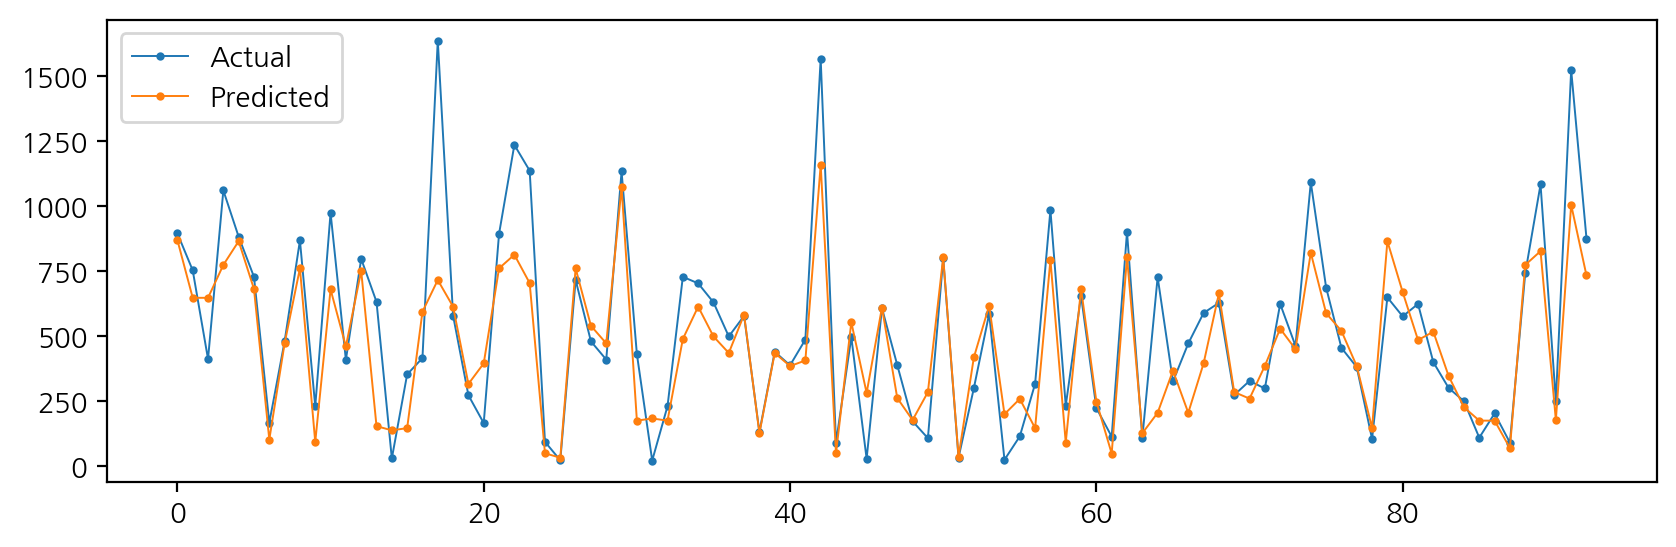

MAE :  127.38279569892474
r2_score :  0.7113167675778247


In [18]:
param = {'n_neighbors':range(1,50)}

model_KNN = GridSearchCV(KNeighborsRegressor(),
                    param,
                    cv=10)

model_KNN.fit(x_train_s,y_train)
y_pred_KNN = model_KNN.predict(x_test_s)
model_plot(y_test,y_pred_KNN)
print('MAE : ',mean_absolute_error(y_test,y_pred_KNN))
print('r2_score : ',r2_score(y_test,y_pred_KNN))

result['KNN']=r2_score(y_test,y_pred_KNN)

### (4) 모델 3: 알고리즘 : Decision tree

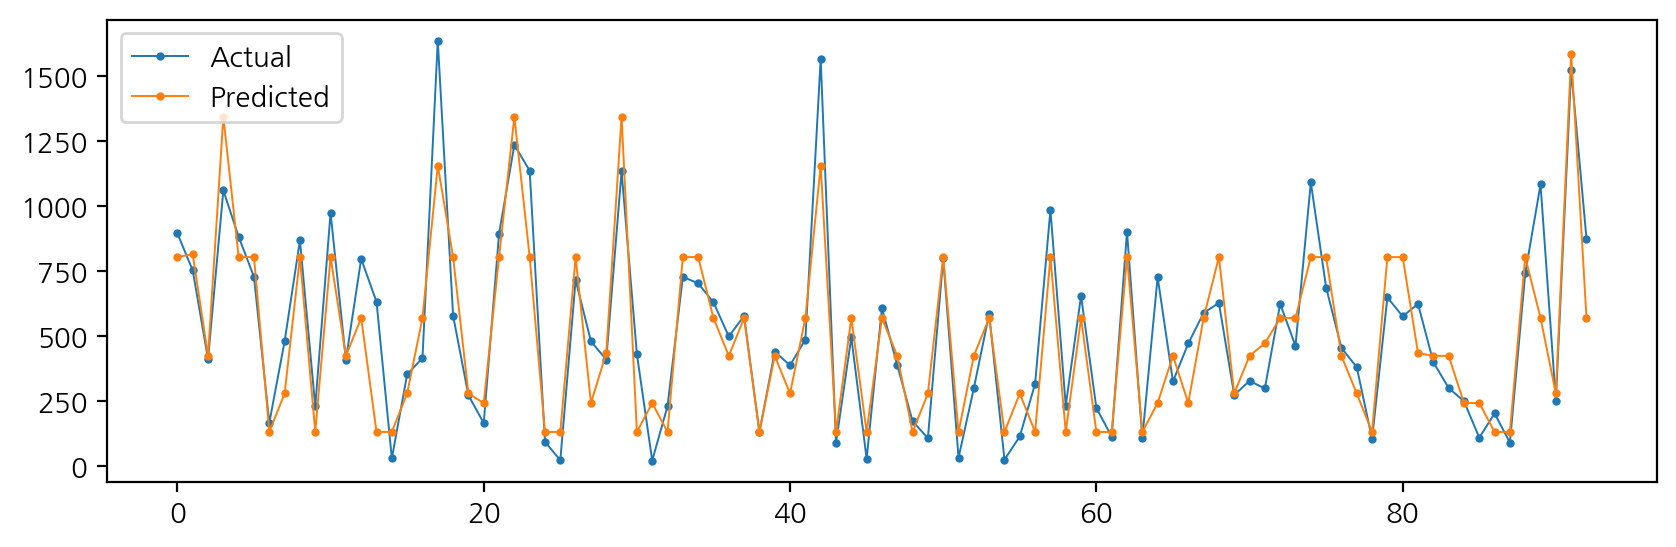

MAE :  124.4971138031622
r2_score :  0.779738170125737


In [19]:

param = {'max_depth':range(1,50)}

model_DT = GridSearchCV(DecisionTreeRegressor(),
                    param,
                    cv=10)
model_DT.fit(x_train_s,y_train)
y_pred_DT = model_DT.predict(x_test_s)
model_plot(y_test,y_pred_DT)
print('MAE : ',mean_absolute_error(y_test,y_pred_DT))
print('r2_score : ',r2_score(y_test,y_pred_DT))

result['Decision tree']=r2_score(y_test,y_pred_DT)

Text(0.5, 0, '중요도')

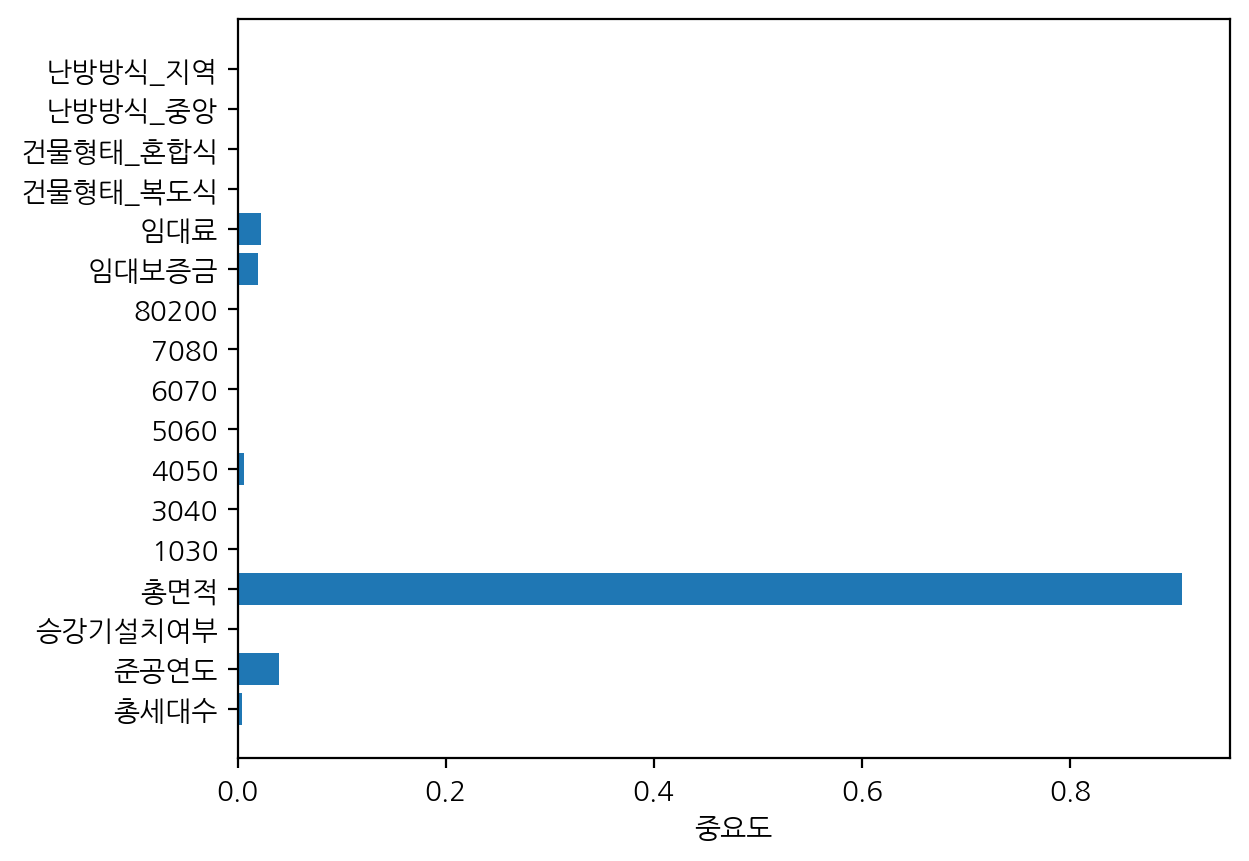

In [20]:
plt.barh(list(x),model_DT.best_estimator_.feature_importances_)
plt.xlabel('중요도')

### (5) 모델 4: 알고리즘 : 앙상블(랜덤포레스트)

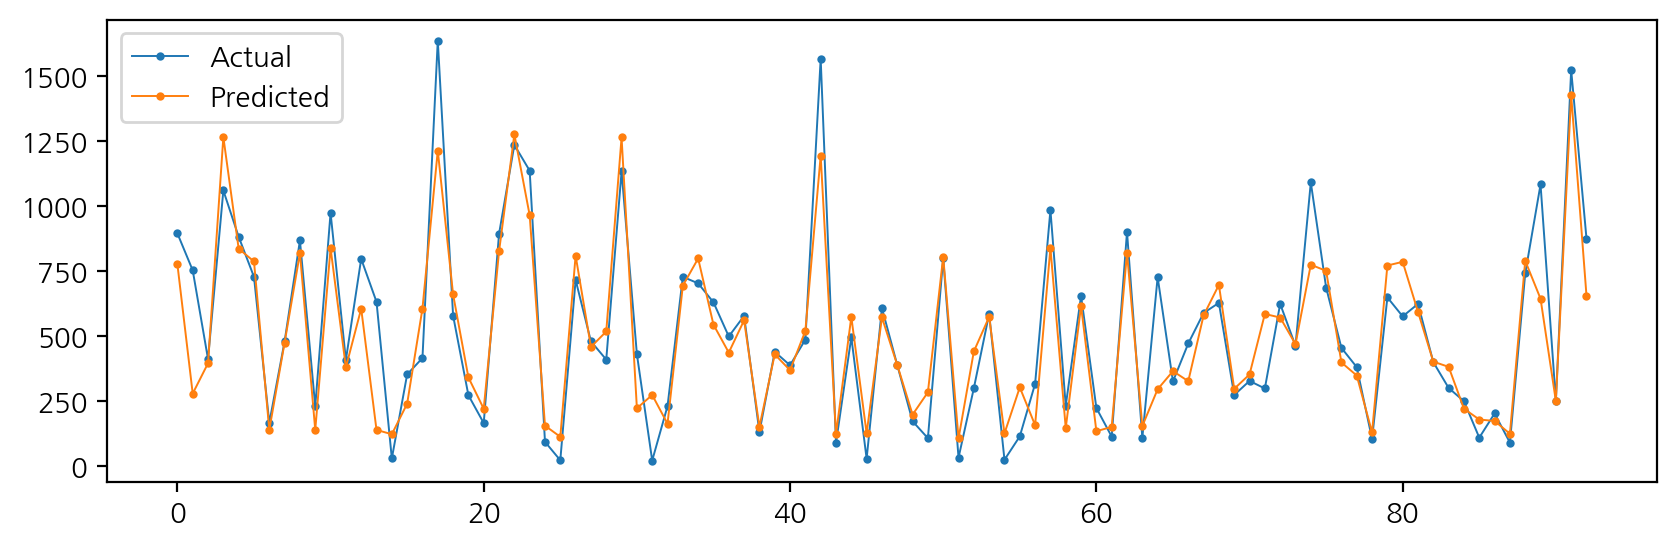

MAE :  103.95625024770509
r2_score :  0.822883083912223


In [21]:
param = {'max_depth':range(3,5),
         'n_estimators': range(200,300,100),  # Corrected 'n_estimators'
         'min_samples_split': range(2, 5)}

model_RF = GridSearchCV(RandomForestRegressor(),
                       param,
                       cv=10
                       )
model_RF.fit(x_train,y_train)
y_pred_RF = model_RF.predict(x_test)
model_plot(y_test,y_pred_RF)
print('MAE : ',mean_absolute_error(y_test,y_pred_RF))
print('r2_score : ',r2_score(y_test,y_pred_RF))                     

result['Random Forest']=r2_score(y_test,y_pred_RF)

Text(0.5, 0, '중요도')

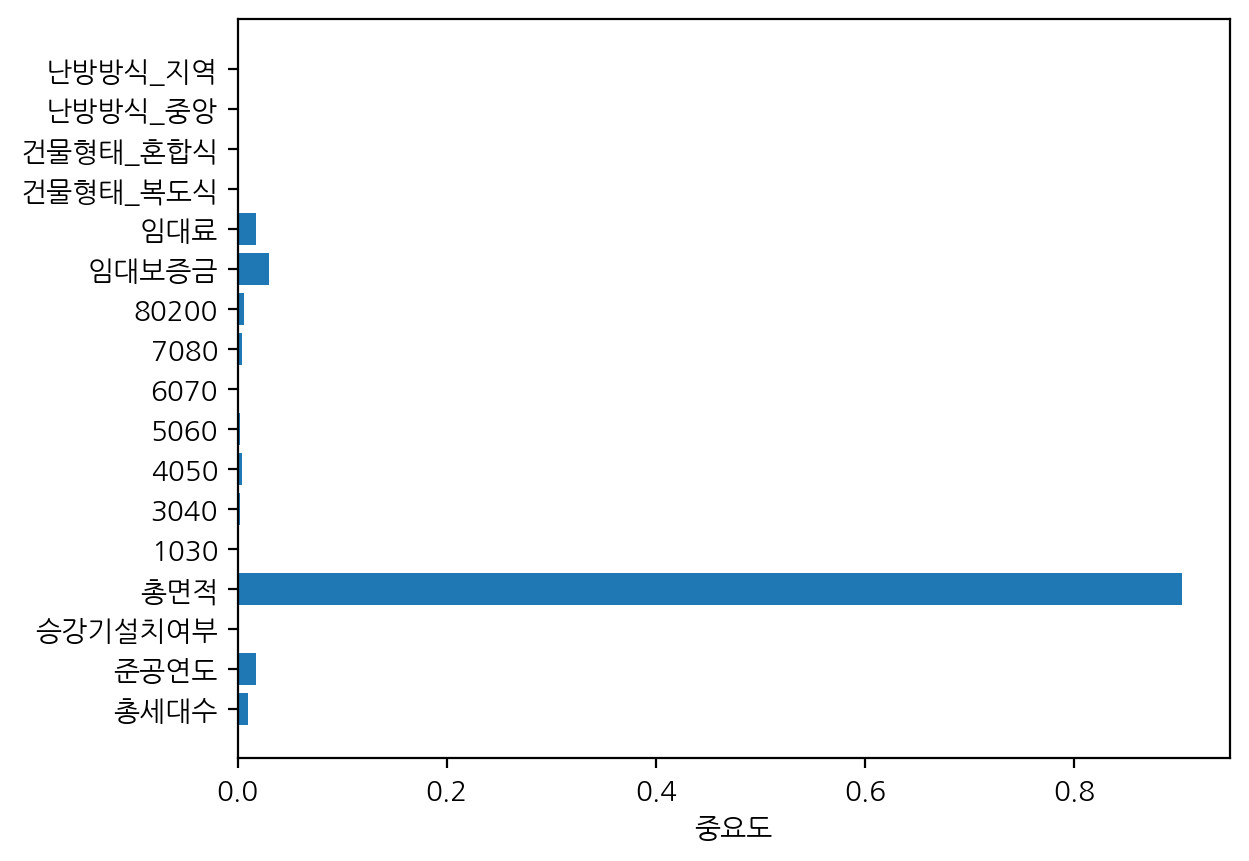

In [22]:
plt.barh(list(x),model_RF.best_estimator_.feature_importances_)
plt.xlabel('중요도')

### (6) 모델 5: 알고리즘 : XGBoost

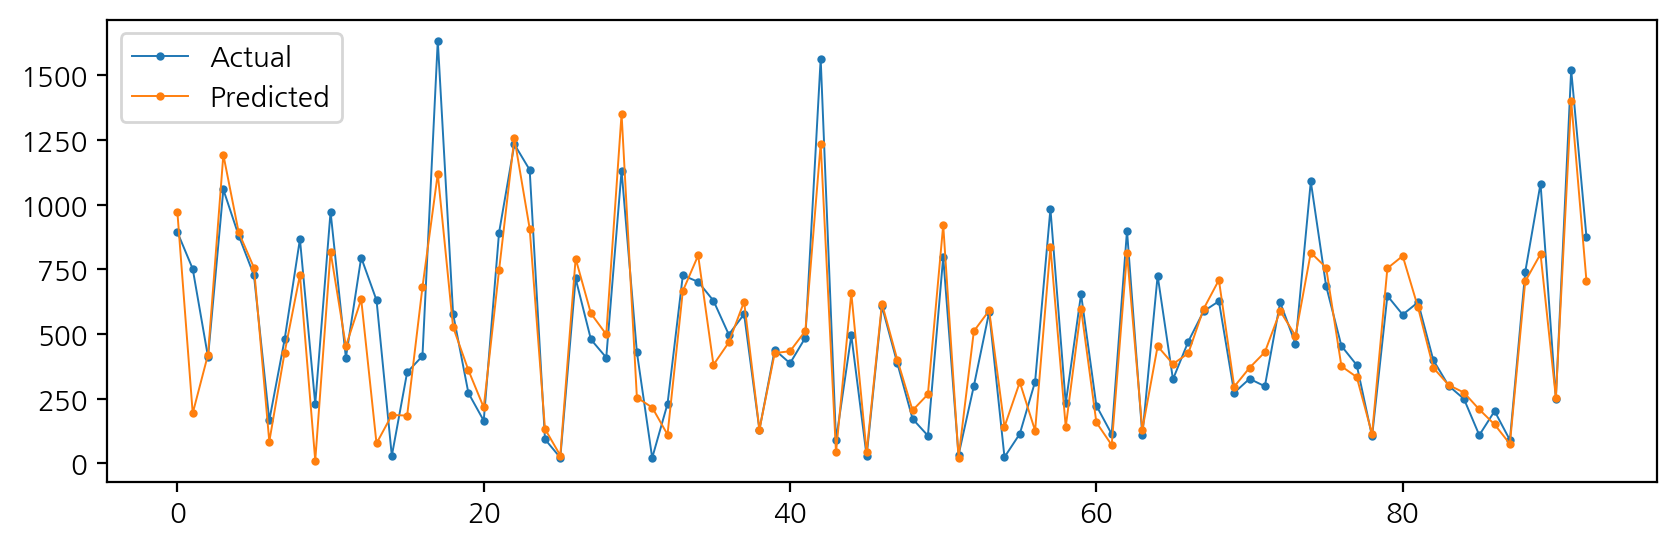

MAE :  108.08592003647999
r2_score :  0.8139833311489295


In [24]:
param = {'max_depth':range(3,5),
        "n_estimators":  range(200,300,100),  # 트리의 개수 (학습 반복 수)
        'colsample_bytree': np.arange(0.7, 1.1, 0.1)}  # 트리 생성 시 사용할 열의 비율}

model_XGB = GridSearchCV(XGBRegressor(),
                       param,
                       cv=10
                       )
model_XGB.fit(x_train,y_train)
y_pred_XGB = model_XGB.predict(x_test)
model_plot(y_test,y_pred_XGB)
print('MAE : ',mean_absolute_error(y_test,y_pred_XGB))
print('r2_score : ',r2_score(y_test,y_pred_XGB))         

result['XGBoost']=r2_score(y_test,y_pred_XGB)

Text(0.5, 0, '중요도')

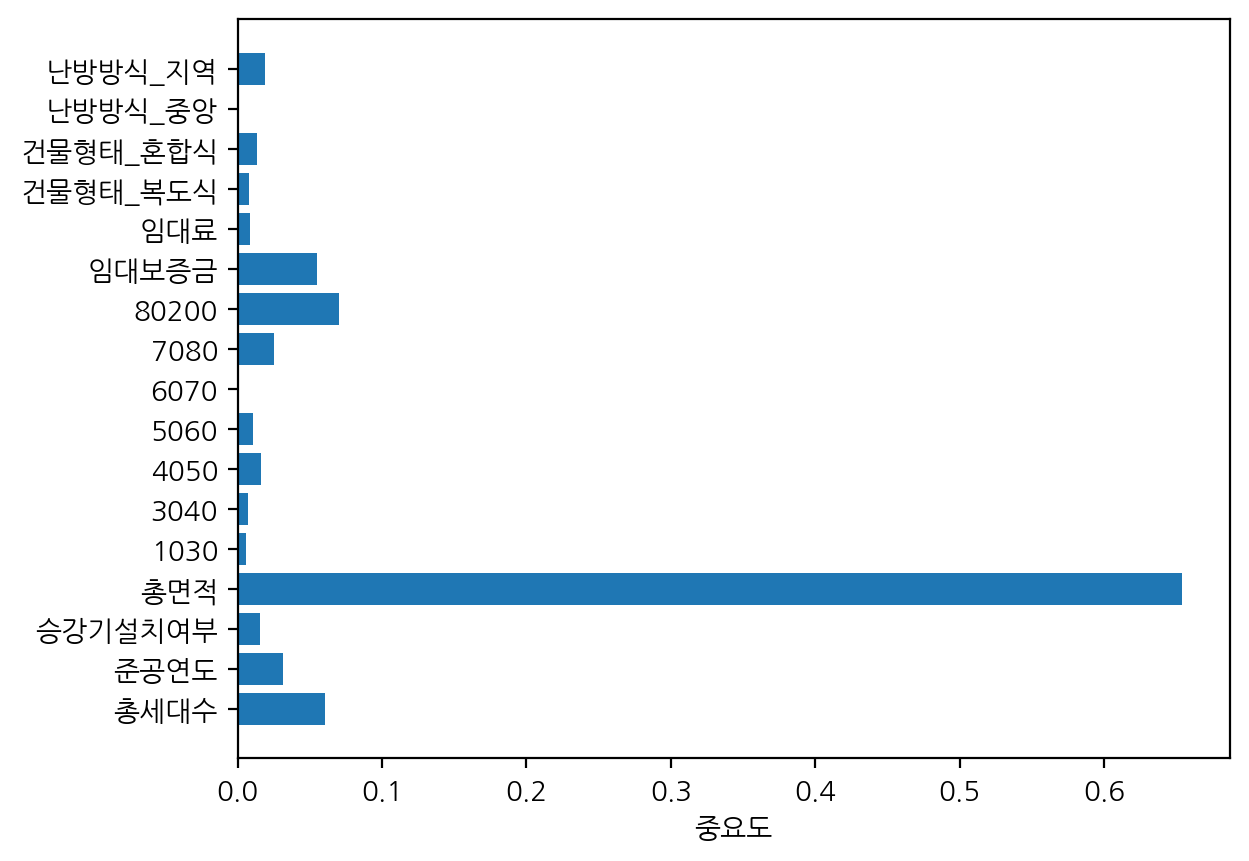

In [25]:
plt.barh(list(x),model_XGB.best_estimator_.feature_importances_)
plt.xlabel('중요도')

### (6) 모델 6: 알고리즘 : LightGBM

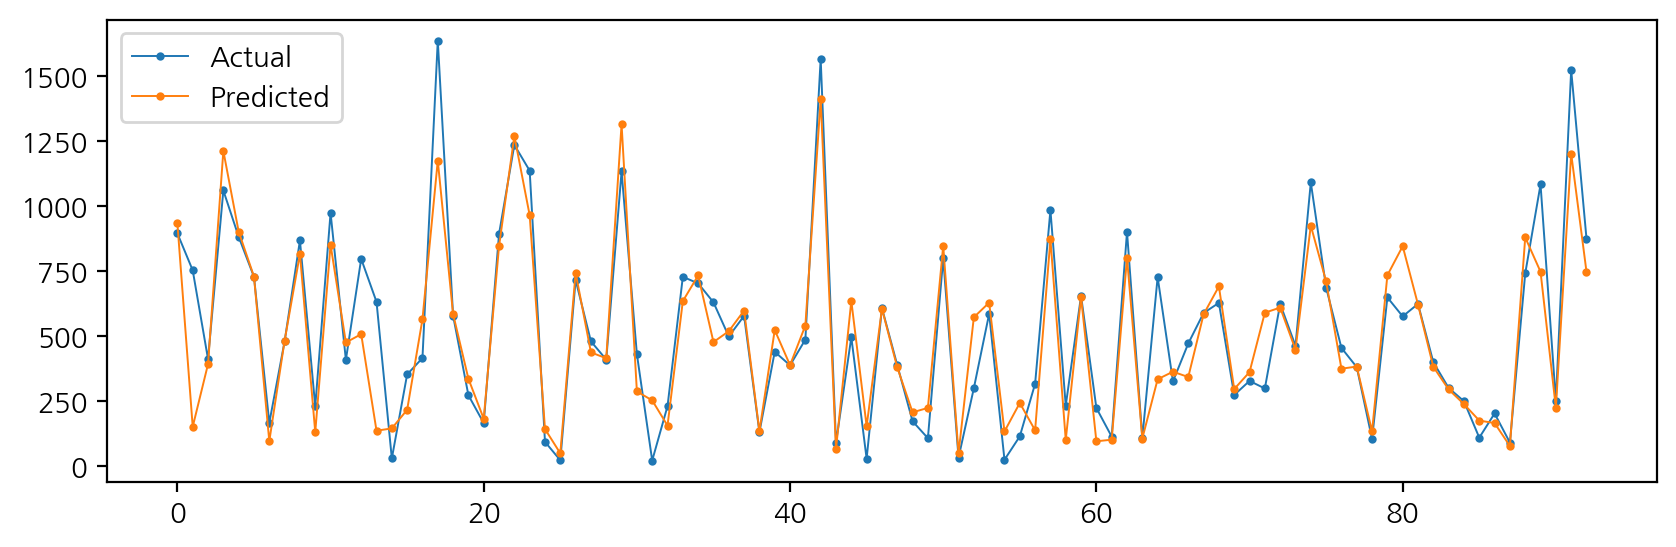

MAE :  98.12130347295472
r2_score :  0.8236989754276325


In [26]:
param = {'max_depth':range(3,5)}

model_LGBM = GridSearchCV(LGBMRegressor(verbose=-1),
                       param,
                       cv=10
                       )
model_LGBM.fit(x_train,y_train)
y_pred_LGBM = model_LGBM.predict(x_test)
model_plot(y_test,y_pred_LGBM)
print('MAE : ',mean_absolute_error(y_test,y_pred_LGBM))
print('r2_score : ',r2_score(y_test,y_pred_LGBM))         
result['LightGBM']=r2_score(y_test,y_pred_LGBM)

Text(0.5, 0, '중요도')

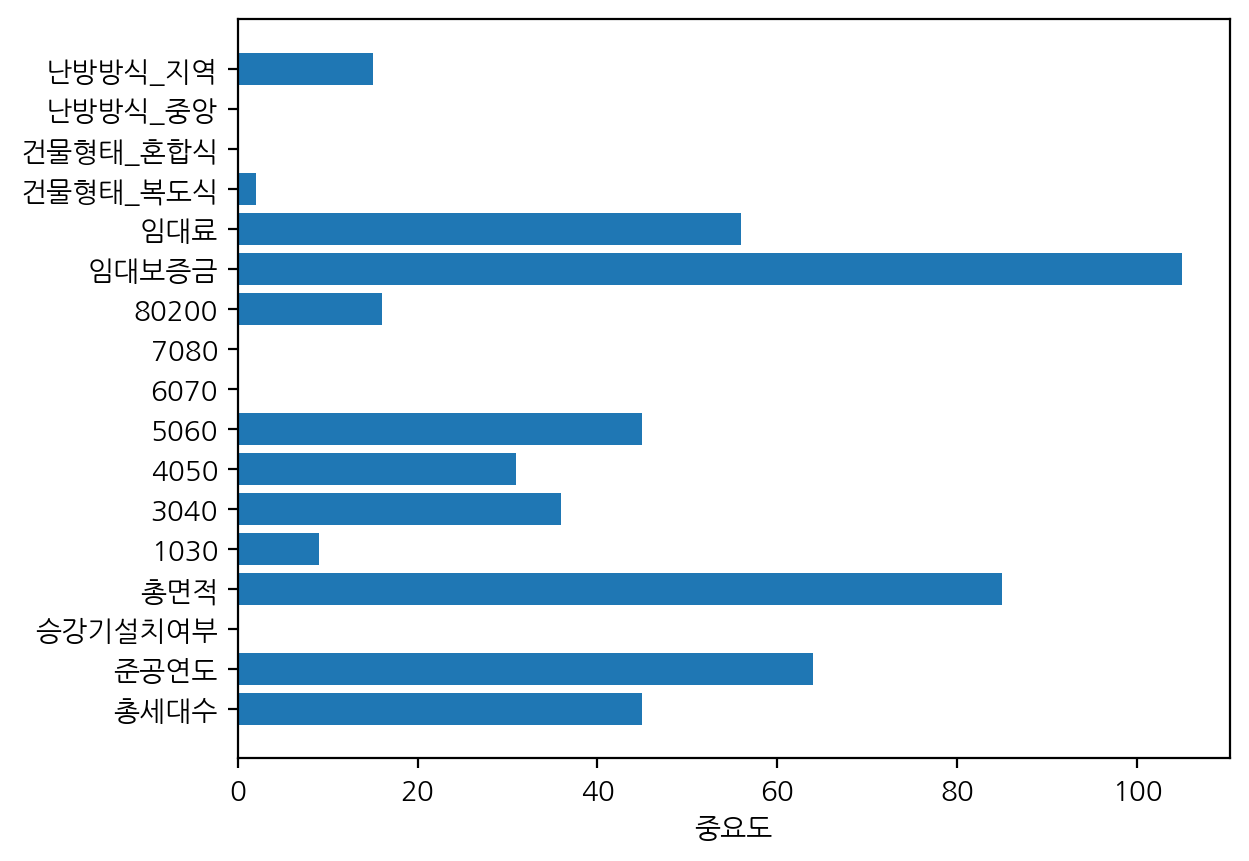

In [27]:
plt.barh(list(x),model_LGBM.best_estimator_.feature_importances_)
plt.xlabel('중요도')

### (7) 성능 비교

- 각 모델의 성능을 비교합니다.

In [28]:
result

{'Linear Regression': 0.7156301514831418,
 'KNN': 0.7113167675778247,
 'Decision tree': 0.779738170125737,
 'Random Forest': 0.822883083912223,
 'XGBoost': 0.8139833311489295,
 'LightGBM': 0.8236989754276325}

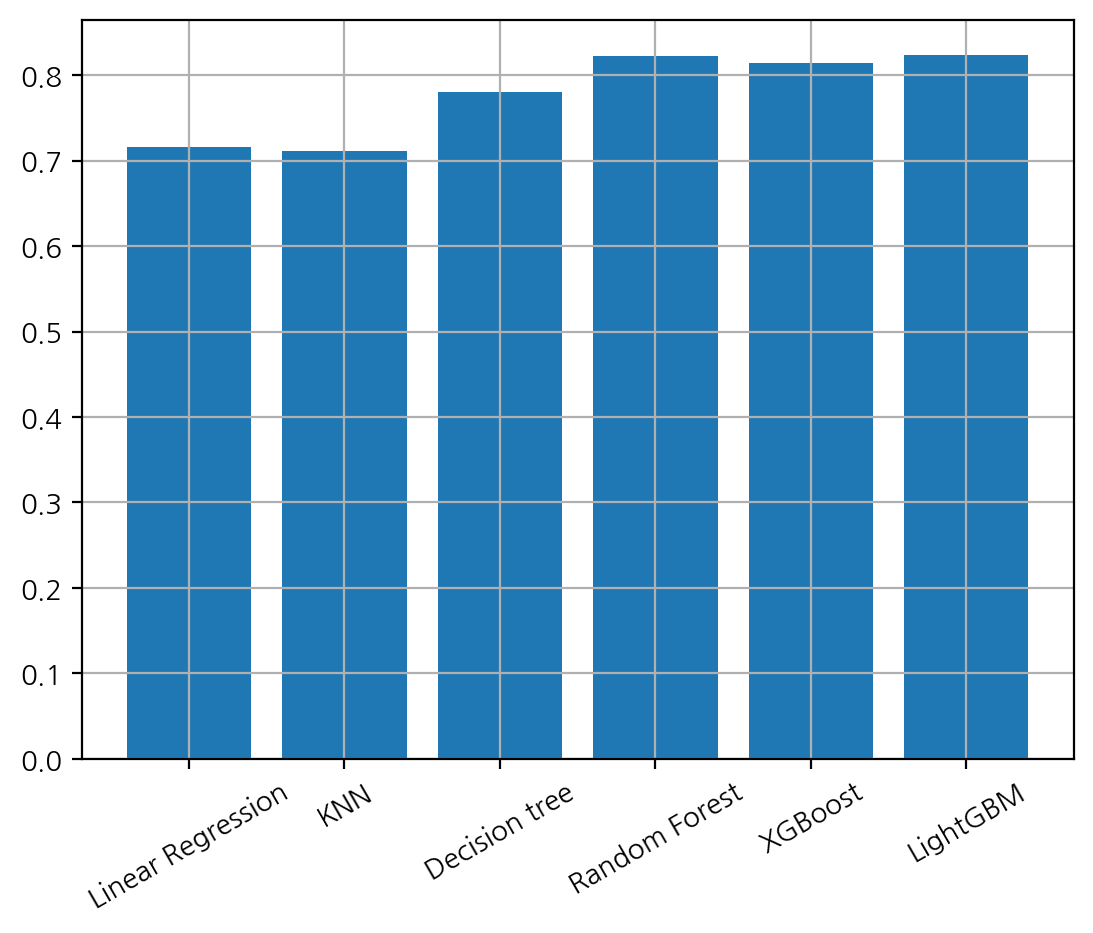

In [29]:
plt.bar(list(result),result.values())
plt.grid()
plt.xticks(rotation=30)
plt.show()

## 3. 파이프라인 구축

- 새로운 데이터를 불러오고, 이 데이터를 처리할 파이프라인 함수를 만듭니다.

### (1) New Data 불러오기

- test.xlsx 파일을 읽어와 new_data 데이터프레임으로 선언합니다.
- 해당 데이터는 '실차량수' 변수가 없는 것 외에는, 최초 데이터와 동일한 구조입니다.
- 이 데이터를 대상으로 전처리와 예측을 수행합니다.

In [30]:
# 파일 읽어오기
new_data = pd.read_excel(path+'test.xlsx')

# 확인
new_data.head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료
0,C0005,서울석촌 도시형주택(공임10년),20,6,서울,20121115,복도식,개별가스난방,전체동 설치,9,17.53,11.7251,50449000,263710
1,C0005,서울석촌 도시형주택(공임10년),20,10,서울,20121115,복도식,개별가스난방,전체동 설치,9,24.71,16.5275,52743000,321040
2,C0005,서울석촌 도시형주택(공임10년),20,4,서울,20121115,복도식,개별가스난방,전체동 설치,9,26.72,17.8720,53890000,332510
3,C0017,대구혁신센텀힐즈,822,228,대구경북,20180221,계단식,지역난방,NaN,824,51.87,20.9266,29298000,411200
4,C0017,대구혁신센텀힐즈,822,56,대구경북,20180221,계단식,지역난방,NaN,824,59.85,24.1461,38550000,462600


### (2) 데이터 파이프라인 구축

- 데이터 파이프라인 함수를 만듭니다.
- 학습 데이터에 대해 진행했던 모든 전처리 과정을 평가 데이터에도 일괄 진행해야 합니다.
    - 입력: new_data
    - 출력: 전처리가 완료된 예측 직전 데이터프레임
- 새로운 데이터에는 '실차량수' 변수가 없음을 유의합니다.
- 참고: 다음 내용들이 처리되어야 합니다.
    - 결측치 처리
    - 변수 추가
    - 불필요한 변수 제거
    - 단지 데이터, 상세 데이터 분리
    - 단지코드별 총면적 합 집계
    - 전용면적 구간별 집계 (피벗 형태)
    - 임대보증금, 임대료 평균 집계
    - 집계 결과 병합
    - 난방방식: 개별, 지역, 중앙 세 가지로 묶기
    - 승강기설치여부: 0, 1 값으로 변경
    - 단지모드, 지역 변수 제거
    - 가변수화

In [31]:
new_data.isna().sum()

단지코드        0
단지명         0
총세대수        0
전용면적별세대수    0
지역          0
준공일자        0
건물형태        4
난방방식        1
승강기설치여부     9
단지내주차면수     0
전용면적        0
공용면적        0
임대보증금       0
임대료         0
dtype: int64

In [32]:
# 파이프라인 만들기
def data_pipeline(data):
    apt01 = data.copy()
    
    ##결측치 처리
    apt01['건물형태'].fillna(apt01['건물형태'].mode()[0],inplace=True)                 
    apt01['난방방식'].fillna(apt01['난방방식'].mode()[0],inplace=True)
    apt01['승강기설치여부'].fillna(apt01['승강기설치여부'].mode()[0],inplace=True)
    
    ##준공연도 열 추가
    apt01['준공연도'] = [int(day/10000) for day in apt01['준공일자']]                 

    ## 불필요한 변수 제거
    drop_col = ['단지명','단지내주차면수','준공일자']                        
    apt01.drop(drop_col,axis=1,inplace=True)

    #단지 데이터, 상세 데이터 분리
    data01 = apt01[['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부']]      
    data01.drop_duplicates(inplace=True)
    data01.reset_index(drop=True,inplace=True)

    #단지 데이터, 상세 데이터 분리
    data02=apt01[['단지코드','전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료']]              
    data02['총면적']=(data02['전용면적']+data02['공용면적'])*data02['전용면적별세대수']

    #단지코드별 총면적 합 집계
    df_area = data02.groupby('단지코드').sum()[['총면적']]                                           
    df_area.reset_index(inplace=True)


    #전용면적 구간별 집계 (피벗 형태)
    labels = ['1030', '3040', '4050', '5060', '6070', '7080', '80200']
    data02['전용면적구간'] = pd.cut(data02['전용면적'], bins=[10,30,40,50,60,70,80,200], labels=labels)             

    temp = data02.groupby(['단지코드','전용면적구간']).sum()[['전용면적별세대수']]

    df_pivot = temp.pivot_table(index='단지코드',columns='전용면적구간',values='전용면적별세대수')
    df_pivot.columns.name=None
    df_pivot.reset_index(inplace=True)
    df_pivot['1030'] = [int(a) for a in df_pivot['1030']]
    df_pivot['3040'] = [int(a) for a in df_pivot['3040']]
    df_pivot['4050'] = [int(a) for a in df_pivot['4050']]
    df_pivot['5060'] = [int(a) for a in df_pivot['5060']]
    df_pivot['6070'] = [int(a) for a in df_pivot['6070']]
    df_pivot['7080'] = [int(a) for a in df_pivot['7080']]
    df_pivot['80200'] = [int(a) for a in df_pivot['80200']]

    #임대보증금, 임대료 평균 집계
    df_rent = data02.groupby('단지코드')[['임대보증금','임대료']].mean()                                     
    df_rent.reset_index(inplace=True)

    #집계 결과 병합
    base_data = pd.merge(data01,df_area,how='left',on='단지코드')                                          
    base_data = pd.merge(base_data, df_pivot,how='left',on='단지코드')
    base_data = pd.merge(base_data, df_rent,how='left',on='단지코드')


    #난방방식: 개별, 지역, 중앙 세 가지로 묶기
    base_data['난방방식'] = np.where(((base_data['난방방식']=='개별가스난방') | (base_data['난방방식']=='개별유류난방')) , '개별',
                        np.where(((base_data['난방방식']=='지역난방') | (base_data['난방방식']=='지역가스난방') | (base_data['난방방식']=='지역유류난방')),'지역','중앙'))

    #승강기설치여부: 0, 1 값으로 변경
    base_data['승강기설치여부'] = np.where(base_data['승강기설치여부']=='전체동 설치',1,0)

    #단지모드, 지역 변수 제거
    base_data.drop(['단지코드','지역'],axis=1,inplace= True)

    #가변수화
    dumm_cols = ['건물형태','난방방식']

    base_data = pd.get_dummies(base_data,columns=dumm_cols,drop_first=True,dtype=int)

    return base_data

### (3) 예측하기

- new_data를 파이프라인을 사용해 전처리한 후 가장 성능이 좋았던 모델로 예측한 결과를 확인합니다.

In [33]:
# 데이터 전처리
data = data_pipeline(new_data)

# 확인
data.head()

,총세대수,준공연도,승강기설치여부,총면적,1030,3040,4050,5060,6070,7080,80200,임대보증금,임대료,건물형태_복도식,건물형태_혼합식,난방방식_중앙,난방방식_지역
0,20,2012,1,766.2736,20,0,0,0,0,0,0,5.236067e+07,305753.333333,1,0,0,0
1,822,2018,1,31396.0944,0,0,0,404,0,0,0,3.546600e+07,445466.666667,0,0,0,1
2,112,2014,1,12450.4308,0,0,0,0,0,20,92,9.869750e+07,744450.000000,0,0,0,1
3,122,2011,1,13081.4772,0,0,0,0,0,22,100,0.000000e+00,0.000000,0,0,0,1
4,262,2011,1,28141.7516,0,0,0,0,0,77,185,0.000000e+00,0.000000,0,0,0,1


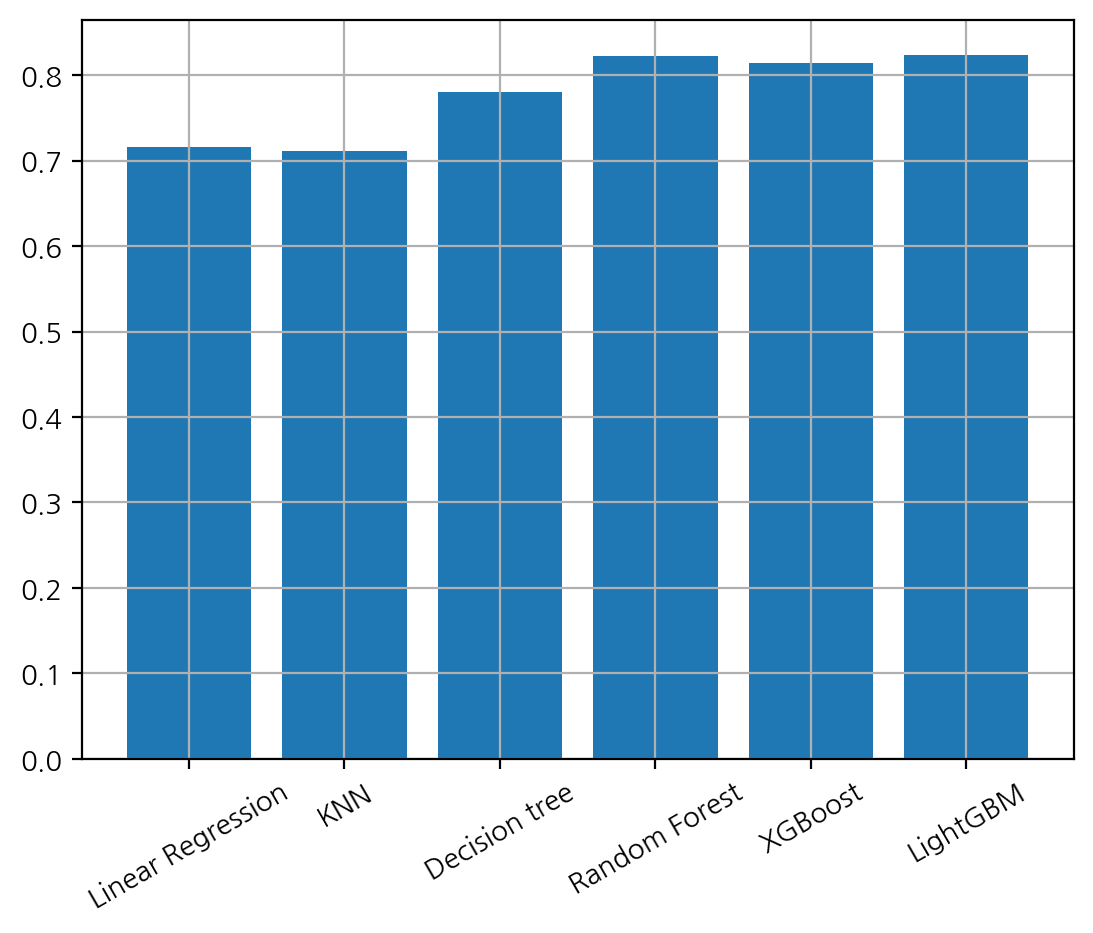

In [34]:
plt.bar(list(result),result.values())
plt.grid()
plt.xticks(rotation=30)
plt.show()

In [36]:
# 예측하기 (r2_score 가 가장 높은 Random Forest,XGBoost 와 LightGBM 로 예측)
predicted_RF = model_RF.predict(data)

# 확인
print(predicted_RF)

[ 262.75148314  478.19585984  498.41589535  293.24280286  380.66203971
  191.1210318   265.7476414   223.85305266  209.84417527  406.27564389
  259.96688222  127.82410149 1429.18641846  696.0000803   548.62420975
  780.00350419  608.1995265   135.27404655  795.22016602  882.8455978
  254.85868069  832.17577768  826.75141866  830.54049652  825.23459496
  162.24389392  139.58497043 1322.2882942   293.3649835   694.0626618 ]


In [37]:
# 예측하기 (r2_score 가 가장 높은 Random Forest,XGBoost 와 LightGBM 로 예측)
predicted_LGBM= model_LGBM.predict(data)

# 확인
print(predicted_LGBM)

[ 252.26807752  596.0616993   469.86848931  159.05926657  340.89313937
  194.81498151  160.26338661  179.89139215  195.39472601  397.76979909
  269.82416931  103.98679507 1303.31281647  764.43793916  538.61481692
  791.5629291   613.66048749  147.5533465  1005.15238415  907.14808475
  281.14796157  865.87205276  742.72502926  850.39755866  923.98981896
  175.31852306   66.97023206 1049.27089329  247.67057167  778.93789577]


In [38]:
# 예측하기 (r2_score 가 가장 높은 Random Forest,XGBoost 와 LightGBM 로 예측)
predicted_XGB= model_XGB.predict(data)

# 확인
print(predicted_XGB)

[ 210.15321  615.7107   773.6696   432.8504   431.15857  242.2506
  481.5109   376.07785  343.84116  330.9783   257.80432   75.08714
 1366.7002   664.9385   597.6244   797.3071   566.64075  199.48015
 1048.7805   913.3826   249.81409  848.7537   768.91034  813.5935
  928.86346  200.21413   71.35043  997.27435  258.20908  826.9133 ]


- 아파트 기본 정보에 예측한 차량수를 붙여 마무리합니다.

In [45]:
# 데이터 셋 두개로 나누기
vars = ['단지코드', '단지명', '총세대수', '지역', ]
result_RF = new_data[vars].copy()
result_RF = result_RF.drop_duplicates()
result_RF.reset_index(drop=True, inplace=True)

# 예측 결과 추가
result_RF['예상차량수'] = predicted_RF.round(1).astype(int)

# 확인
result_RF

,단지코드,단지명,총세대수,지역,예상차량수
0,C0005,서울석촌 도시형주택(공임10년),20,서울,262
1,C0017,대구혁신센텀힐즈,822,대구경북,478
2,C0034,광교 호반마을 22단지 아파트,112,경기,498
3,C0046,죽미마을 휴먼시아12단지,122,경기,293
4,C0055,파주운정 한울마을 6단지,262,경기,380
5,C0072,벌교제석휴먼시아,35,광주전남,191
6,C0073,무안남악오룡마을,47,광주전남,265
7,C0084,진해 석동우림필유 아파트,152,경남,223
8,C0085,김해북부 두산위브 아파트,73,경남,209
9,C0112,운암주공6단지아파트,571,경기,406


In [46]:
# 데이터 셋 두개로 나누기
vars = ['단지코드', '단지명', '총세대수', '지역', ]
result_LGBM = new_data[vars].copy()
result_LGBM = result_LGBM.drop_duplicates()
result_LGBM.reset_index(drop=True, inplace=True)

# 예측 결과 추가
result_LGBM['예상차량수'] = predicted_LGBM.round(1).astype(int)

# 확인
result_LGBM

,단지코드,단지명,총세대수,지역,예상차량수
0,C0005,서울석촌 도시형주택(공임10년),20,서울,252
1,C0017,대구혁신센텀힐즈,822,대구경북,596
2,C0034,광교 호반마을 22단지 아파트,112,경기,469
3,C0046,죽미마을 휴먼시아12단지,122,경기,159
4,C0055,파주운정 한울마을 6단지,262,경기,340
5,C0072,벌교제석휴먼시아,35,광주전남,194
6,C0073,무안남악오룡마을,47,광주전남,160
7,C0084,진해 석동우림필유 아파트,152,경남,179
8,C0085,김해북부 두산위브 아파트,73,경남,195
9,C0112,운암주공6단지아파트,571,경기,397


In [47]:
# 데이터 셋 두개로 나누기
vars = ['단지코드', '단지명', '총세대수', '지역', ]
result_XGB = new_data[vars].copy()
result_XGB = result_XGB.drop_duplicates()
result_XGB.reset_index(drop=True, inplace=True)

# 예측 결과 추가
result_XGB['예상차량수'] = predicted_XGB.round(1).astype(int)

# 확인
result_XGB

,단지코드,단지명,총세대수,지역,예상차량수
0,C0005,서울석촌 도시형주택(공임10년),20,서울,210
1,C0017,대구혁신센텀힐즈,822,대구경북,615
2,C0034,광교 호반마을 22단지 아파트,112,경기,773
3,C0046,죽미마을 휴먼시아12단지,122,경기,432
4,C0055,파주운정 한울마을 6단지,262,경기,431
5,C0072,벌교제석휴먼시아,35,광주전남,242
6,C0073,무안남악오룡마을,47,광주전남,481
7,C0084,진해 석동우림필유 아파트,152,경남,376
8,C0085,김해북부 두산위브 아파트,73,경남,343
9,C0112,운암주공6단지아파트,571,경기,331


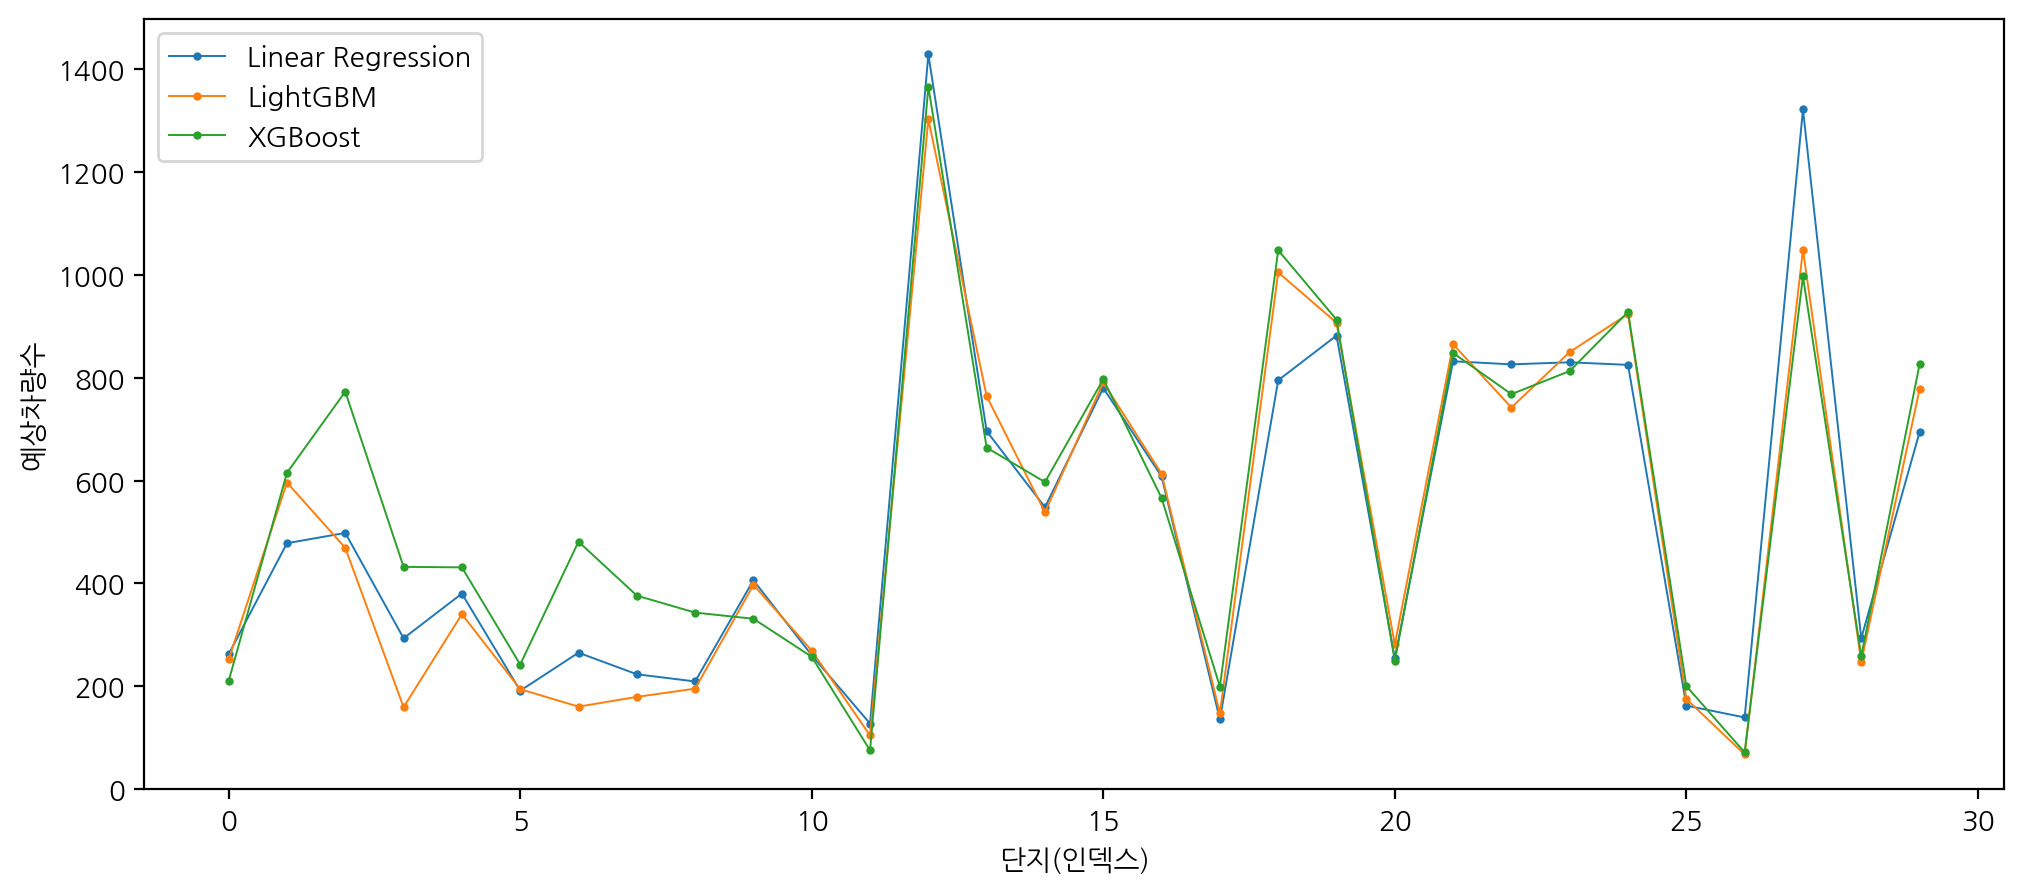

In [49]:

plt.figure(figsize=(12,5))
plt.plot(result_RF['예상차량수'],label='Linear Regression',linewidth=0.7, marker='o', markersize=2)
plt.plot(result_LGBM['예상차량수'],label='LightGBM',linewidth=0.7, marker='o', markersize=2)
plt.plot(result_XGB['예상차량수'],label='XGBoost',linewidth=0.7, marker='o', markersize=2)
plt.ylabel('예상차량수')
plt.xlabel('단지(인덱스)')
plt.legend()
plt.show()